# Mel Frequency Filterbank Reconstruction

Reconstruct a signal (after compressing) from MFCC filters. The concepts are taken from [Boucheron and Leon](http://www.ece.nmsu.edu/~pdeleon/Research/Publications/ICSES_2008.pdf). 


In [1]:
# Speech Libraries
from python_speech_features import mfcc, get_filterbanks
from python_speech_features.sigproc import deframesig

from python_speech_features import logfbank

## Wave libraries
from IPython.display import Audio
from IPython.display import display
import scipy.io.wavfile as wav

## Standard python libraries
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Signal and rate
(rate,sig) = wav.read('sisec/dev_Ca1_Ce_A_src.wav')

# Parameters
nfilt=64
numcep=64
nfft=512
winlen=0.01
winstep=0.005
ceplifter=0

## Take MFCC's of a `*.wav` file

This is where we extract MFCC features from the wave file. At this point, it is worth noting what the arguments are for the N00Bs (as we all are.) The definition of MFCC features can be expressed as:

$$C = \mathcal{DCT}\left\{ \Phi \log | \mathcal{DFT}(\hat{\mathbf{x}}) | \right\}$$

Here, $\mathbf{x}$ is the framed up original, time-domain signal that has been windowed (typically a Hamming window is applied) and organized into frames. So, if there are $N$ frames with window of length $K$, then the frames are stacked into $\hat{\mathbf{x}} \in K \times N$ array. 

The $\Phi$ is simply a re-weighting that takes into account which frequencies actually matter. These are the *Mel frequencies*, and can be shown here: ![Mel Frequencies](melfreq.png)


The toolbox `python_speech_features` takes all of this into account, but you have to understand what the parameters mean in order to have an intuition of what problems they solve.  Specifically, the parameters to keep an eye out for are:

- `nfft` - Number of FFT points in your signal; it's the dimensionality of $X = \mathcal{DFT}(\hat{\mathbf{x}})$
- `nfilt` - Afterward, you subselect according to Mel bins; nfilt decides which ones are centered around it.
- `numcep` = Number of cepstral coefficients. This will ultimately be the dimensionality of your features, i.e. $\mathbf{C}$, with the caveats below

The *actual dimensionality of your final feature* is really `min(nfilt, numcep)`. 

In [3]:
# %debug --breakpoint try_speech.py:160
mfcc_feat = mfcc(sig,rate,nfilt=nfilt,numcep=numcep,nfft=nfft,
                 winlen=winlen,winstep=winstep,ceplifter=ceplifter,
                 appendEnergy=False)

## Frequency conversion

Find $\Phi$ and $\Phi^{\dagger}$, where $\Phi^{\dagger}$ is the Moore Penrose pseudoinverse. The first step is to find what $\Phi$ is, which is provided by `python_speech_features.py`. The system is underdetermined, and so $\Phi^{\dagger}$ is the *minimum norm* solution to the inverse in lieu of $\Phi^{-1}$ being underdetermined and therefore singular. For reference, there is also a least squares solution, labeled `Phi_LS`.

In [4]:
Phi = get_filterbanks(nfilt=nfilt,nfft=nfft,
                      samplerate=rate,lowfreq=0,highfreq=None)
Phi_MN = Phi.T @ np.linalg.inv( Phi @ Phi.T )
Phi_LS = np.linalg.inv( Phi @ Phi.T ) @ Phi

## Getting the phase using libraries from `python_speech_features`

Since `python_speech_features` takes spectrograms differently than you or I might, the below. 

In [5]:
from python_speech_features import sigproc

def specdecomp(signal,samplerate=16000,winlen=0.025,winstep=0.01,
              nfft=nfft,lowfreq=0,highfreq=None,preemph=0.97,
              winfunc=lambda x:np.ones((x,)),decomp='complex'):

    """Compute the magnitude spectrum of each frame in frames. If frames is an NxD matrix, output will be Nx(NFFT/2+1). 
    :param frames: the array of frames. Each row is a frame.
    :param NFFT: the FFT length to use. If NFFT > frame_len, the frames are zero-padded. 
    :returns: If frames is an NxD matrix, output will be Nx(NFFT/2+1). Each row will be the magnitude spectrum of the corresponding frame.
    """    
    
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    if decomp=='time' or decomp=='frames':
        return frames
    
    complex_spec = np.fft.rfft(frames,nfft)    
    if decomp=='magnitude' or decomp=='mag' or decomp=='abs':
        return np.abs(complex_spec)
    elif decomp=='phase' or decomp=='angle':
        return np.angle(complex_spec)
    elif decomp=='power' or decomp=='powspec':
        return sigproc.powspec(frames,nfft)
    else:
        return complex_spec        
    return spect

mfcc_phase = specdecomp(sig,samplerate=rate,nfft=nfft,
                        winlen=0.01,winstep=0.005,decomp='phase')

## Recover FFT magnitude

First recover the magnitude response through power spectrum.

In [19]:
from scipy.fftpack import dct,idct

# Inverse DCT
idct_pow = idct(mfcc_feat, type=2, axis=1, norm='ortho').T

# Reconstruct the power spectrum
# recon_pow = np.exp(Phi_MN @ idct_pow).T
Phi_NZ = ( Phi.T > 0.75 ).astype(np.int16 )
recon_pow = np.exp( Phi_NZ @ idct_pow ).T

# Reconstruct the magnitude response
recon_mag = np.sqrt( recon_pow*nfft )

# Reconstruct the inverse FFT with the magnitude and original phase
recon_fft = recon_mag * np.exp( 1j* mfcc_phase )
recon_frames = np.fft.irfft( recon_fft, n=int(winlen*rate) )

# Reconstruct signal from frames
recon_sig = deframesig(recon_frames, 0, winlen*rate, winstep*rate)

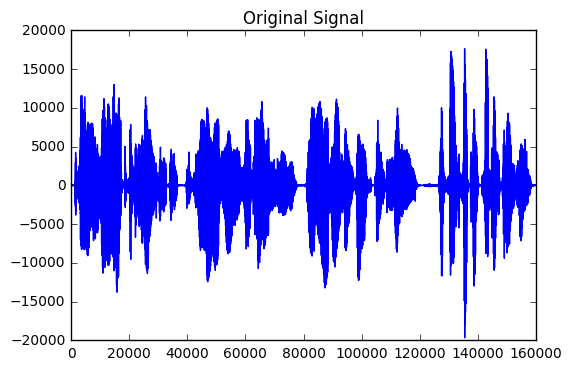

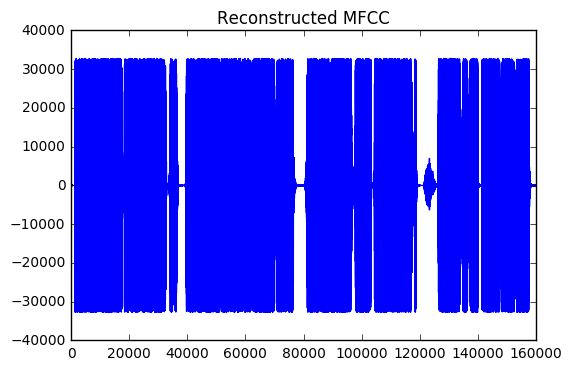

In [18]:
recon_sig = recon_sig.astype(np.int16)
plt.figure(); plt.plot(sig); plt.title('Original Signal')
plt.figure(); plt.plot(recon_sig); plt.title('Reconstructed MFCC')
display(Audio(sig,rate=rate))
display(Audio(recon_sig,rate=rate))
